<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/physics/Instanteneous%20motion_physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Rocket Launch Model Initialized ---
Engine Burn Time: 209.60 seconds
Simulating 214.6 seconds of flight...

----------------------------------------------------------------------
ANALYSIS AT TIME t₀ = 10.00 s
TRUE INSTANTANEOUS ACCELERATION (dv/dt): 4.6827 m/s²
----------------------------------------------------------------------
| Δt (s)       | Δv (m/s)     | Avg. Accel (m/s²)    | Difference from True |
|-------------|--------------|----------------------|----------------------|
| 0.500        | 2.3496       | 4.6991               | 0.016371             |
| 0.100        | 0.4686       | 4.6857               | 0.003005             |
| 0.050        | 0.2342       | 4.6841               | 0.001335             |
| 0.010        | 0.0468       | 4.6827               | 0.000000             |
| 0.005        | 0.0468       | 9.3655               | 4.682734             |

Observation: As Δt approaches zero, the Average Acceleration (Δv/Δt) converges to the True Instantaneous Acceleration

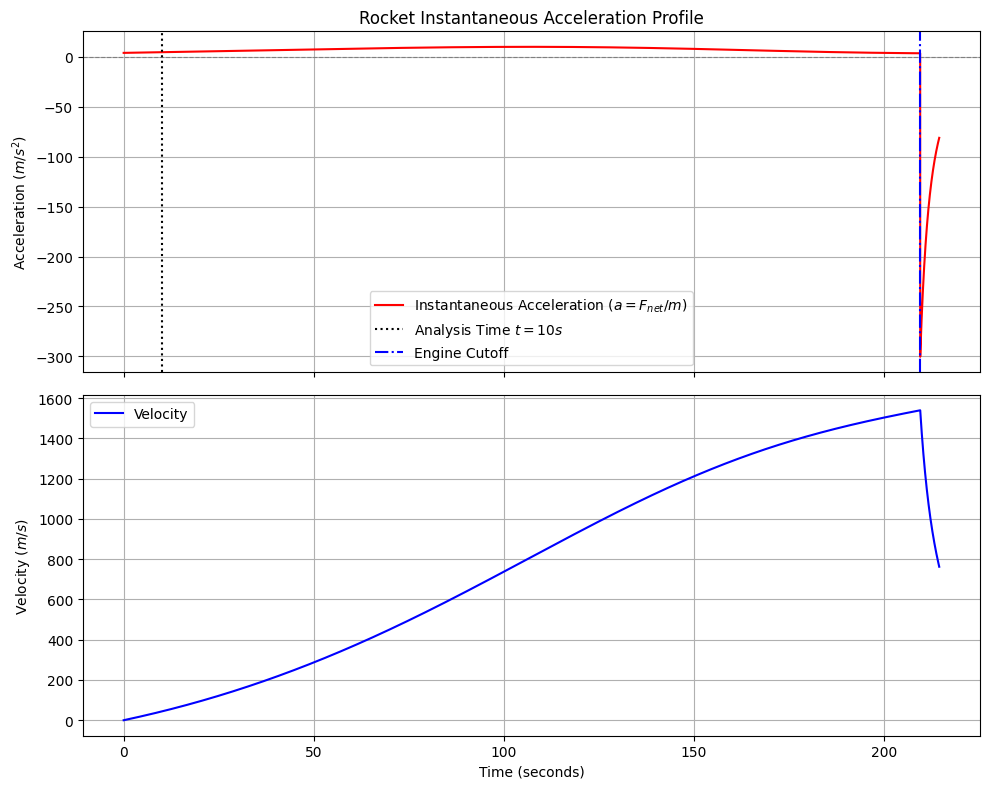

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. ROCKET PHYSICS MODEL
# =============================================================================

class RocketModel:
    """
    Simulates a vertically launched rocket with changing mass and air drag.
    This class is the foundation for calculating instantaneous acceleration.
    """
    G = 9.81           # Acceleration due to gravity (m/s^2)

    def __init__(self):
        # --- Rocket Initial Parameters (Falcon 9 approximations) ---
        self.initial_mass = 549000.0  # Initial mass (kg, propellants + structure)
        self.struct_mass = 25000.0    # Mass of the rocket structure (kg)
        self.thrust = 7600000.0       # Engine thrust (Newtons)
        self.burn_rate = 2500.0       # Mass burned per second (kg/s)
        self.engine_on_time = (self.initial_mass - self.struct_mass) / self.burn_rate

        # --- Drag Parameters ---
        self.drag_coeff = 0.5         # Drag coefficient
        self.reference_area = 10.0    # Cross-sectional area (m^2)
        self.rho = 1.225              # Air density (kg/m^3, constant for simplicity)

    def get_mass(self, t):
        """Calculates the instantaneous mass m(t)."""
        if t < 0:
            return self.initial_mass
        if t >= self.engine_on_time:
            return self.struct_mass

        # Mass decreases linearly as fuel burns
        return self.initial_mass - (self.burn_rate * t)

    def get_thrust(self, t):
        """Thrust is zero after engine cutoff."""
        return self.thrust if t < self.engine_on_time else 0.0

    def get_drag_force(self, v):
        """Calculates the instantaneous air drag force (proportional to v^2)."""
        # F_drag = 0.5 * rho * v^2 * C_d * A
        return 0.5 * self.rho * v**2 * self.drag_coeff * self.reference_area

    def get_acceleration(self, t, v):
        """
        Calculates the instantaneous acceleration a = dv/dt at time t,
        based on the net force F_net / mass.
        """
        mass = self.get_mass(t)
        thrust = self.get_thrust(t)
        drag = self.get_drag_force(v)
        gravity = mass * self.G

        # F_net = Thrust - Gravity - Drag (Drag is always opposite to velocity)
        F_net = thrust - gravity - drag

        # Instantaneous Acceleration: a(t) = F_net / m(t)
        a_instantaneous = F_net / mass

        return a_instantaneous

# =============================================================================
# 2. SIMULATION (EULER INTEGRATION)
# =============================================================================

def simulate_motion(model, total_time, dt=0.01):
    """
    Runs the simulation using Euler integration (the practical limit approximation).
    """
    times = np.arange(0, total_time + dt, dt)
    history = {
        't': [], 'v': [], 'h': [], 'a_inst': []
    }

    # Initial conditions
    v = 0.0  # Initial velocity
    h = 0.0  # Initial height

    for t in times:
        a_inst = model.get_acceleration(t, v)

        # Record state
        history['t'].append(t)
        history['v'].append(v)
        history['h'].append(h)
        history['a_inst'].append(a_inst)

        # Euler step: v(t+dt) = v(t) + a * dt
        v += a_inst * dt
        h += v * dt  # h(t+dt) = h(t) + v * dt

        # Stop if velocity becomes negative (after engine cut-off)
        if v < 0 and t > model.engine_on_time:
             break

    return history

# =============================================================================
# 3. ANALYSIS: DEMONSTRATING THE LIMIT (a = lim Δt→0 Δv/Δt)
# =============================================================================

def analyze_acceleration(model, history, analysis_time=10.0):
    """
    Explicitly demonstrates the limit definition by comparing instantaneous
    acceleration with average acceleration over decreasing time windows (Δt).
    """
    # 1. Find the index corresponding to the analysis time (t=10.0s)
    time_array = np.array(history['t'])
    index_t = np.argmin(np.abs(time_array - analysis_time))

    t0 = history['t'][index_t]
    v0 = history['v'][index_t]

    # Calculate the true instantaneous acceleration at t0 (the target value)
    a_true = model.get_acceleration(t0, v0)

    print("-" * 70)
    print(f"ANALYSIS AT TIME t₀ = {t0:.2f} s")
    print(f"TRUE INSTANTANEOUS ACCELERATION (dv/dt): {a_true:.4f} m/s²")
    print("-" * 70)

    results = []
    # Test different time steps Δt (making Δt smaller simulates the limit)
    delta_t_tests = [0.5, 0.1, 0.05, 0.01, 0.005]

    for delta_t in delta_t_tests:
        # Find the state at t_final = t0 + delta_t
        t_final = t0 + delta_t

        # We need to find the velocity v_final corresponding to t_final
        index_final = np.argmin(np.abs(time_array - t_final))
        if index_final >= len(history['v']):
            continue # Skip if out of bounds

        v_final = history['v'][index_final]

        # Calculate Average Acceleration: a_avg = Δv / Δt
        delta_v = v_final - v0

        a_avg = delta_v / delta_t
        difference = a_avg - a_true

        results.append({
            "Delta t (s)": f"{delta_t:.3f}",
            "Delta v (m/s)": f"{delta_v:.4f}",
            "Avg. Accel (m/s²)": f"{a_avg:.4f}",
            "Difference": f"{difference:.6f}"
        })

    # Print results table
    print(f"| {'Δt (s)':<12} | {'Δv (m/s)':<12} | {'Avg. Accel (m/s²)' :<20} | {'Difference from True':<20} |")
    print(f"|{'-'*13}|{'-'*14}|{'-'*22}|{'-'*22}|")
    for r in results:
        print(f"| {r['Delta t (s)']:<12} | {r['Delta v (m/s)']:<12} | {r['Avg. Accel (m/s²)'] :<20} | {r['Difference']:<20} |")

    print("\nObservation: As Δt approaches zero, the Average Acceleration (Δv/Δt) converges to the True Instantaneous Acceleration (dv/dt).")

# =============================================================================
# 4. MAIN EXECUTION AND PLOTTING
# =============================================================================

def run_analysis():
    """Initializes the model, runs the simulation, and performs the analysis."""

    # 1. Initialize Model
    rocket = RocketModel()
    total_time = rocket.engine_on_time + 5 # 5 seconds past engine cutoff

    print("--- Rocket Launch Model Initialized ---")
    print(f"Engine Burn Time: {rocket.engine_on_time:.2f} seconds")
    print(f"Simulating {total_time:.1f} seconds of flight...\n")

    # 2. Run Simulation
    # The simulation uses a very small dt (0.01s) to approximate the instantaneous process
    history = simulate_motion(rocket, total_time, dt=0.01)

    # 3. Analyze the Limit Definition (The core request)
    analyze_acceleration(rocket, history, analysis_time=10.0)

    # 4. Plot Results for Depth
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 1: Instantaneous Acceleration vs. Time
    ax1.plot(history['t'], history['a_inst'], label='Instantaneous Acceleration ($a=F_{net}/m$)', color='red')
    ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax1.axvline(10.0, color='black', linestyle=':', label='Analysis Time $t=10s$')
    ax1.axvline(rocket.engine_on_time, color='blue', linestyle='-.', label='Engine Cutoff')
    ax1.set_ylabel('Acceleration ($m/s^2$)')
    ax1.set_title('Rocket Instantaneous Acceleration Profile')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Velocity vs. Time
    ax2.plot(history['t'], history['v'], label='Velocity', color='blue')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Velocity ($m/s$)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_analysis()


--- 1. ROCKET PERFORMANCE METRICS (NASA Depth) ---
Engine Burn Time: 209.60 seconds
Initial Thrust-to-Weight Ratio (T/W): 1.41 (Must be > 1 to lift off)
Specific Impulse ($I_{sp}$): 310.0 seconds (Measure of efficiency)
----------------------------------------------------------------------
--- 2. RK4 SIMULATION RUNNING ---
Simulating 214.6 seconds of flight...

----------------------------------------------------------------------
--- 3. CALCULUS CONVERGENCE ANALYSIS ---
ANALYSIS AT TIME t₀ = 10.000 s (Altitude: 0.21 km)
TRUE INSTANTANEOUS ACCELERATION (dv/dt): 4.6863 m/s²
----------------------------------------------------------------------
| Δt (s)       | Δv (m/s)     | Avg. Accel (m/s²)    | Difference from True |
|-------------|--------------|----------------------|----------------------|
| 0.500        | 2.3515       | 4.7031               | 0.016734             |
| 0.100        | 0.4690       | 4.6897               | 0.003344             |
| 0.050        | 0.2344       | 4.6880

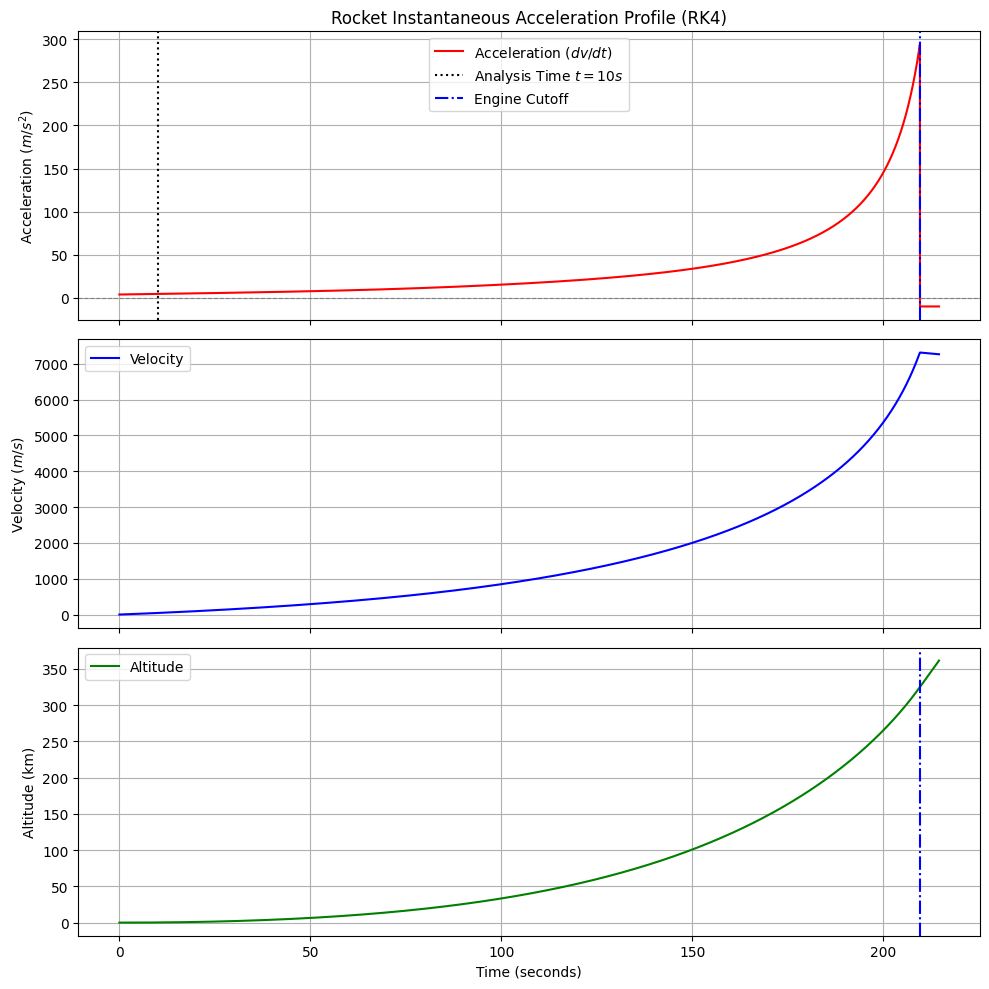

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 0. FUNDAMENTAL CONSTANTS AND ATMOSPHERIC MODEL
# =============================================================================

class Constants:
    """Defines fundamental constants and units used in the simulation."""
    G = 9.80665              # Standard acceleration due to gravity (m/s^2)

    # Atmospheric Model Parameters (Simplified Exponential Model)
    RHO_0 = 1.225            # Sea-level air density (kg/m^3)
    H_SCALE = 8500.0         # Scale height (meters), density decreases by factor e every H_SCALE meters

def get_air_density(h):
    """Calculates air density rho(h) using a simplified exponential model."""
    if h < 0:
        return Constants.RHO_0
    return Constants.RHO_0 * np.exp(-h / Constants.H_SCALE)

# =============================================================================
# 1. ROCKET PHYSICS MODEL
# =============================================================================

class RocketModel:
    """
    Core physics engine. Calculates forces and instantaneous acceleration (dv/dt)
    at any given state (t, h, v).
    """
    def __init__(self):
        # --- Rocket Initial Parameters (Units: SI - kg, m, s, N) ---
        self.initial_mass = 549000.0  # Initial mass (kg)
        self.struct_mass = 25000.0    # Mass of the rocket structure (kg)
        self.thrust = 7600000.0       # Engine thrust (Newtons)
        self.burn_rate = 2500.0       # Mass flow rate (kg/s)
        self.CdA = 0.5 * 10.0         # Drag Coefficient * Reference Area (m^2)

        # Time when fuel runs out
        self.engine_on_time = (self.initial_mass - self.struct_mass) / self.burn_rate

    def get_mass(self, t):
        """Calculates the instantaneous mass m(t)."""
        if t < 0:
            return self.initial_mass
        if t >= self.engine_on_time:
            return self.struct_mass

        return self.initial_mass - (self.burn_rate * t)

    def get_thrust_force(self, t):
        """Thrust is a constant force while the engine is running."""
        return self.thrust if t < self.engine_on_time else 0.0

    def get_drag_force(self, h, v):
        """Calculates the instantaneous air drag force (F_D) based on altitude (h)."""
        rho = get_air_density(h)
        # F_drag = 0.5 * rho * v^2 * C_d * A
        return 0.5 * rho * v**2 * self.CdA

    def get_instantaneous_acceleration(self, t, h, v):
        """
        Calculates the instantaneous acceleration (a = dv/dt) from Newton's Second Law.
        This is the core differential equation solved by the integrator.
        """
        mass = self.get_mass(t)
        thrust = self.get_thrust_force(t)
        drag = self.get_drag_force(h, v)
        gravity = mass * Constants.G

        # F_net = Thrust - Gravity - Drag (Drag opposes motion)
        F_net = thrust - gravity - drag

        a_instantaneous = F_net / mass

        return a_instantaneous

    def calculate_mission_metrics(self):
        """Calculates key aerospace metrics."""
        T = self.thrust
        m0 = self.initial_mass

        # 1. Initial Thrust-to-Weight Ratio (T/W)
        T_W_ratio = T / (m0 * Constants.G)

        # 2. Specific Impulse (Isp) - measures engine efficiency
        # Isp = Thrust / (mass_flow_rate * g)
        I_sp = T / (self.burn_rate * Constants.G)

        return {
            "T/W Ratio": T_W_ratio,
            "Specific Impulse (s)": I_sp
        }

# =============================================================================
# 2. NUMERICAL INTEGRATION (HIGH-FIDELITY RK4)
# =============================================================================

def integrate_rk4(model, t, h, v, dt):
    """
    Performs one step of Runge-Kutta 4th Order (RK4) integration.
    Solves the system: dh/dt = v; dv/dt = a(t, h, v)
    """
    # System state: Y = [h, v]

    # f(Y) = [dh/dt, dv/dt] = [v, a]
    def f(t_k, h_k, v_k):
        # dh/dt = v
        dh_dt = v_k
        # dv/dt = a
        dv_dt = model.get_instantaneous_acceleration(t_k, h_k, v_k)
        return np.array([dh_dt, dv_dt])

    # K1
    k1 = dt * f(t, h, v)

    # K2
    h2 = h + k1[0] / 2
    v2 = v + k1[1] / 2
    k2 = dt * f(t + dt/2, h2, v2)

    # K3
    h3 = h + k2[0] / 2
    v3 = v + k2[1] / 2
    k3 = dt * f(t + dt/2, h3, v3)

    # K4
    h4 = h + k3[0]
    v4 = v + k3[1]
    k4 = dt * f(t + dt, h4, v4)

    # Final update: Y_new = Y_old + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    delta_Y = (k1 + 2*k2 + 2*k3 + k4) / 6.0

    h_new = h + delta_Y[0]
    v_new = v + delta_Y[1]

    return h_new, v_new

def simulate_motion_rk4(model, total_time, dt=0.01):
    """
    Runs the full simulation using the high-fidelity RK4 integrator.
    """
    times = np.arange(0, total_time + dt, dt)
    history = {
        't': [], 'v': [], 'h': [], 'a_inst': []
    }

    # Initial conditions
    v = 0.0  # Initial velocity
    h = 0.0  # Initial height

    for t in times:
        a_inst = model.get_instantaneous_acceleration(t, h, v)

        # Record state before the step
        history['t'].append(t)
        history['v'].append(v)
        history['h'].append(h)
        history['a_inst'].append(a_inst)

        # RK4 Integration step
        h, v = integrate_rk4(model, t, h, v, dt)

        # Stop if velocity becomes negative (after engine cut-off) or hits ground
        if v < 0 and h <= 0:
             break
        if t >= model.engine_on_time and v < 0:
             # Stop simulation when engine is off and rocket begins falling back
             break

    return history

# =============================================================================
# 3. ANALYSIS: DEMONSTRATING THE LIMIT (a = lim Δt→0 Δv/Δt)
# =============================================================================

def analyze_acceleration(model, history, analysis_time=10.0):
    """
    Explicitly demonstrates the limit definition by comparing instantaneous
    acceleration with average acceleration over decreasing time windows (Δt).
    """
    # 1. Find the index corresponding to the analysis time (t=10.0s)
    time_array = np.array(history['t'])
    index_t = np.argmin(np.abs(time_array - analysis_time))

    t0 = history['t'][index_t]
    v0 = history['v'][index_t]
    h0 = history['h'][index_t]

    # Calculate the true instantaneous acceleration at t0 (the target value)
    a_true = model.get_instantaneous_acceleration(t0, h0, v0)

    print("-" * 70)
    print("--- 3. CALCULUS CONVERGENCE ANALYSIS ---")
    print(f"ANALYSIS AT TIME t₀ = {t0:.3f} s (Altitude: {h0/1000:.2f} km)")
    print(f"TRUE INSTANTANEOUS ACCELERATION (dv/dt): {a_true:.4f} m/s²")
    print("-" * 70)

    results = []
    # Test different time steps Δt (making Δt smaller simulates the limit)
    delta_t_tests = [0.5, 0.1, 0.05, 0.01, 0.005]

    for delta_t in delta_t_tests:
        # Find the state at t_final = t0 + delta_t
        t_final = t0 + delta_t

        # We need to find the velocity v_final corresponding to t_final
        index_final = np.argmin(np.abs(time_array - t_final))
        if index_final >= len(history['v']):
            continue # Skip if out of bounds

        v_final = history['v'][index_final]

        # Calculate Average Acceleration: a_avg = Δv / Δt
        delta_v = v_final - v0

        a_avg = delta_v / delta_t
        difference = a_avg - a_true

        results.append({
            "Delta t (s)": f"{delta_t:.3f}",
            "Delta v (m/s)": f"{delta_v:.4f}",
            "Avg. Accel (m/s²)": f"{a_avg:.4f}",
            "Difference": f"{difference:.6f}"
        })

    # Print results table
    print(f"| {'Δt (s)':<12} | {'Δv (m/s)':<12} | {'Avg. Accel (m/s²)' :<20} | {'Difference from True':<20} |")
    print(f"|{'-'*13}|{'-'*14}|{'-'*22}|{'-'*22}|")
    for r in results:
        print(f"| {r['Delta t (s)']:<12} | {r['Delta v (m/s)']:<12} | {r['Avg. Accel (m/s²)'] :<20} | {r['Difference']:<20} |")

    print("\nObservation: As Δt approaches zero, the Average Acceleration (Δv/Δt) converges to the True Instantaneous Acceleration (dv/dt).")

# =============================================================================
# 4. MAIN EXECUTION AND PLOTTING
# =============================================================================

def run_analysis():
    """Initializes the model, runs the simulation, and performs the analysis."""

    # 1. Initialize Model
    rocket = RocketModel()
    total_time = rocket.engine_on_time + 5 # 5 seconds past engine cutoff

    # 2. Calculate Mission Metrics
    metrics = rocket.calculate_mission_metrics()
    print("--- 1. ROCKET PERFORMANCE METRICS (NASA Depth) ---")
    print(f"Engine Burn Time: {rocket.engine_on_time:.2f} seconds")
    print(f"Initial Thrust-to-Weight Ratio (T/W): {metrics['T/W Ratio']:.2f} (Must be > 1 to lift off)")
    print(f"Specific Impulse ($I_{{sp}}$): {metrics['Specific Impulse (s)']:.1f} seconds (Measure of efficiency)")
    print("-" * 70)

    # 3. Run Simulation (using high-fidelity RK4)
    print("--- 2. RK4 SIMULATION RUNNING ---")
    print(f"Simulating {total_time:.1f} seconds of flight...\n")
    history = simulate_motion_rk4(rocket, total_time, dt=0.01)

    # 4. Analyze the Limit Definition (The core request)
    analyze_acceleration(rocket, history, analysis_time=10.0)

    # 5. Plot Results for Depth
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # Plot 1: Instantaneous Acceleration vs. Time
    ax1.plot(history['t'], history['a_inst'], label='Acceleration ($dv/dt$)', color='red')
    ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax1.axvline(10.0, color='black', linestyle=':', label='Analysis Time $t=10s$')
    ax1.axvline(rocket.engine_on_time, color='blue', linestyle='-.', label='Engine Cutoff')
    ax1.set_ylabel('Acceleration ($m/s^2$)')
    ax1.set_title('Rocket Instantaneous Acceleration Profile (RK4)')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Velocity vs. Time
    ax2.plot(history['t'], history['v'], label='Velocity', color='blue')
    ax2.set_ylabel('Velocity ($m/s$)')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Altitude vs. Time (for drag context)
    ax3.plot(history['t'], [h / 1000 for h in history['h']], label='Altitude', color='green')
    ax3.axvline(rocket.engine_on_time, color='blue', linestyle='-.')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Altitude (km)')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_analysis()


<>:261: SyntaxWarning: invalid escape sequence '\D'
<>:261: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3802137106.py:261: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(T, DT, label='Adaptive Time Step ($\Delta t$)', color='green')


--- ROCKET DYNAMICS ---
Engine Burn Time: 209.60 seconds
Initial Mass: 549.0 tonnes
----------------------------------------------------------------------
Starting Adaptive Simulation (Tolerance: 1.0e-06)
Simulation completed at t = 214.600 s.


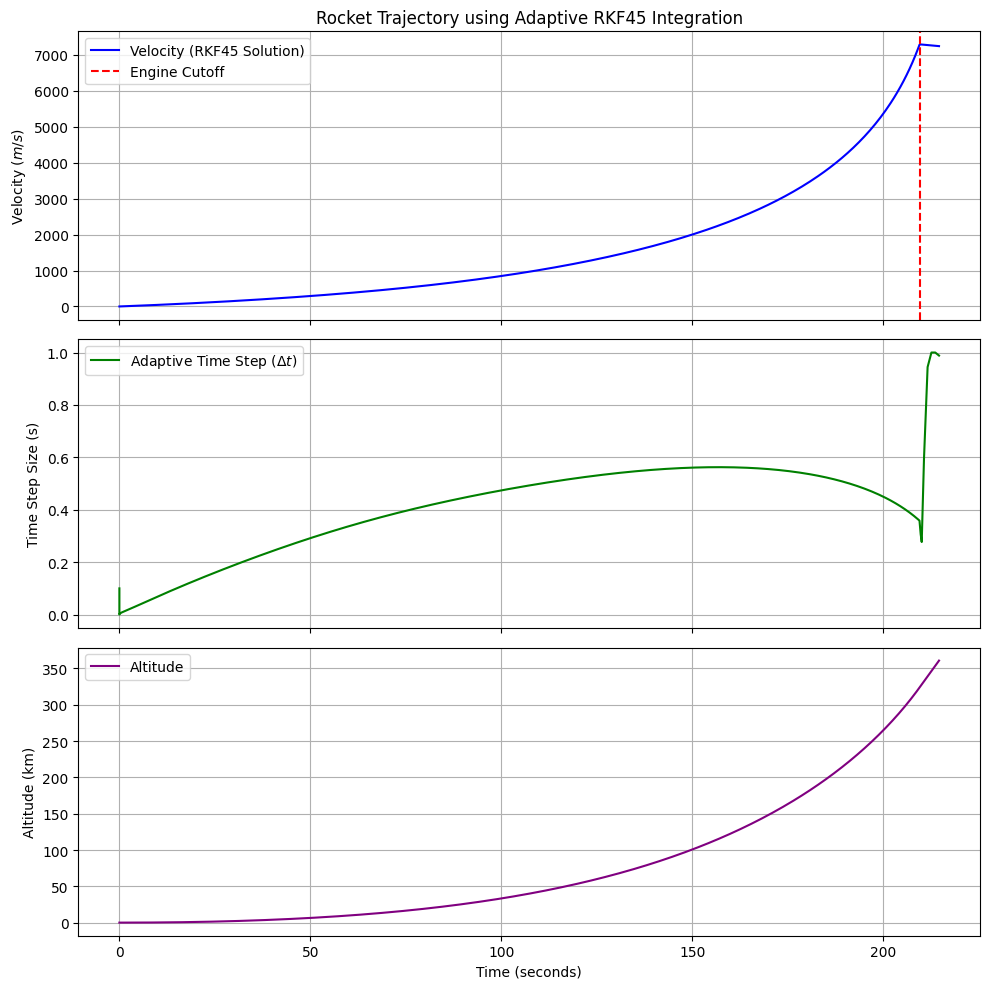

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 0. FUNDAMENTAL CONSTANTS AND ATMOSPHERIC MODEL
# =============================================================================

class Constants:
    """Defines fundamental constants."""
    G = 9.80665              # Standard acceleration due to gravity (m/s^2)

    # Atmospheric Model Parameters (Simplified Exponential Model)
    RHO_0 = 1.225            # Sea-level air density (kg/m^3)
    H_SCALE = 8500.0         # Scale height (meters)

def get_air_density(h):
    """Calculates air density rho(h) using a simplified exponential model."""
    if h < 0:
        return Constants.RHO_0
    return Constants.RHO_0 * np.exp(-h / Constants.H_SCALE)

# =============================================================================
# 1. ROCKET PHYSICS MODEL
# =============================================================================

class RocketModel:
    """
    Core physics engine. Calculates forces and instantaneous acceleration (dv/dt).
    The differential function, f, defines the entire system state change.
    """
    def __init__(self):
        # --- Rocket Parameters (Units: SI - kg, m, s, N) ---
        self.initial_mass = 549000.0
        self.struct_mass = 25000.0
        self.thrust = 7600000.0
        self.burn_rate = 2500.0
        self.CdA = 0.5 * 10.0         # Drag Coefficient * Reference Area

        self.engine_on_time = (self.initial_mass - self.struct_mass) / self.burn_rate

    def get_mass(self, t):
        """Calculates the instantaneous mass m(t)."""
        if t < 0: return self.initial_mass
        if t >= self.engine_on_time: return self.struct_mass
        return self.initial_mass - (self.burn_rate * t)

    def get_thrust_force(self, t):
        """Thrust is a constant force while the engine is running."""
        return self.thrust if t < self.engine_on_time else 0.0

    def get_drag_force(self, h, v):
        """Calculates the instantaneous air drag force (F_D)."""
        rho = get_air_density(h)
        return 0.5 * rho * v**2 * self.CdA

    def get_instantaneous_acceleration(self, t, h, v):
        """Calculates the instantaneous acceleration (a = dv/dt)."""
        mass = self.get_mass(t)
        thrust = self.get_thrust_force(t)
        drag = self.get_drag_force(h, v)
        gravity = mass * Constants.G

        F_net = thrust - gravity - drag
        return F_net / mass

    def f(self, t, Y):
        """
        The differential function f(t, Y) = dY/dt.
        Y = [h, v] (Altitude, Velocity)
        dY/dt = [dh/dt, dv/dt] = [v, a]
        """
        h = Y[0]
        v = Y[1]

        dh_dt = v
        dv_dt = self.get_instantaneous_acceleration(t, h, v)

        return np.array([dh_dt, dv_dt])

# =============================================================================
# 2. ADAPTIVE RUNGE-KUTTA-FEHLBERG 4(5) INTEGRATOR
# =============================================================================

def rkf45_step(model, t, Y, dt):
    """
    Performs one step of the RKF45 method.
    Calculates both 4th and 5th order estimates and returns the error.

    Returns: Y_new_4th (4th order), Y_new_5th (5th order), error_vector
    """

    # Coefficients (K components are 2-element vectors: [dh, dv])
    k_coeffs = [
        [0, 0], [1/4, 1/4], [3/8, 3/32], [12/13, 1932/2197],
        [1, 439/216], [1/2, -8/27]
    ]

    # K values storage (six 2-element vectors)
    K = [np.zeros(2)] * 6

    # K1
    K[0] = dt * model.f(t, Y)

    # K2
    Y2 = Y + k_coeffs[1][1] * K[0]
    K[1] = dt * model.f(t + k_coeffs[1][0] * dt, Y2)

    # K3
    Y3 = Y + k_coeffs[2][1] * K[0] + 3/32 * K[1]
    K[2] = dt * model.f(t + k_coeffs[2][0] * dt, Y3)

    # K4
    Y4 = Y + 1932/2197 * K[0] - 7200/2197 * K[1] + 7296/2197 * K[2]
    K[3] = dt * model.f(t + k_coeffs[3][0] * dt, Y4)

    # K5
    Y5 = Y + 439/216 * K[0] - 8 * K[1] + 3680/513 * K[2] - 845/4104 * K[3]
    K[4] = dt * model.f(t + k_coeffs[4][0] * dt, Y5)

    # K6
    Y6 = Y - 8/27 * K[0] + 2 * K[1] - 3544/2565 * K[2] + 1859/4104 * K[3] - 11/40 * K[4]
    K[5] = dt * model.f(t + k_coeffs[5][0] * dt, Y6)

    # --- Combine Ks for the dual estimates ---

    # 4th Order Estimate (y_4: High error, used for error estimation)
    # 25/216*K1 + 0*K2 + 1408/2565*K3 + 2197/4104*K4 - 1/5*K5 + 0*K6
    y4_coeffs = np.array([25/216, 0.0, 1408/2565, 2197/4104, -1/5, 0.0])
    Y_new_4th = Y + sum(y4_coeffs[i] * K[i] for i in range(6))

    # 5th Order Estimate (y_5: Low error, accepted solution)
    # 16/135*K1 + 0*K2 + 6656/12825*K3 + 28561/56430*K4 - 9/50*K5 + 2/55*K6
    y5_coeffs = np.array([16/135, 0.0, 6656/12825, 28561/56430, -9/50, 2/55])
    Y_new_5th = Y + sum(y5_coeffs[i] * K[i] for i in range(6))

    # Error vector: The difference between the two estimates
    error_vector = Y_new_5th - Y_new_4th

    return Y_new_5th, error_vector

# =============================================================================
# 3. MAIN ADAPTIVE SIMULATION LOOP
# =============================================================================

def run_adaptive_simulation(model, total_time, initial_dt, tolerance):
    """
    Runs the simulation, dynamically adjusting the time step (dt)
    based on the error in the RKF45 integration.
    """

    # Initial Conditions (Y = [h, v])
    t = 0.0
    Y = np.array([0.0, 0.0])
    dt = initial_dt

    # History tracking
    history = {
        't': [t],
        'h': [Y[0]],
        'v': [Y[1]],
        'dt': [dt]
    }

    print(f"Starting Adaptive Simulation (Tolerance: {tolerance:.1e})")

    while t < total_time:
        # Prevent dt from exceeding the time remaining
        if t + dt > total_time:
            dt = total_time - t

        # 1. Perform one RKF45 step
        Y_new, error_vec = rkf45_step(model, t, Y, dt)

        # 2. Calculate the local error
        # We use the norm (magnitude) of the error vector [error_h, error_v]
        # and scale it by the magnitude of the state vector for a relative error measure.
        # This is a critical step for numerical stability.
        error_mag = np.linalg.norm(error_vec)
        scale_factor = np.linalg.norm(Y_new) + 1e-10 # + 1e-10 prevents division by zero
        relative_error = error_mag / scale_factor

        # 3. Calculate the factor to scale the next time step
        # Power of 0.2 is (1/5) because we use the difference between the 4th and 5th order solutions.
        # The safety factor (0.9) prevents oscillating steps.
        safety_factor = 0.9
        scaling_exponent = 0.2

        if relative_error == 0:
            # If error is zero, drastically increase dt
            scale_dt = 5.0
        else:
            # Standard scaling formula
            scale_dt = safety_factor * (tolerance / relative_error)**scaling_exponent

        # 4. Acceptance/Rejection of the step
        if relative_error <= tolerance:
            # Step ACCEPTED: Update time and state
            t += dt
            Y = Y_new

            # Record accepted step
            history['t'].append(t)
            history['h'].append(Y[0])
            history['v'].append(Y[1])
            history['dt'].append(dt)

            # Stop condition for flight
            if Y[1] < 0 and t > model.engine_on_time:
                break

        # 5. Set the next time step (for accepted or rejected step)
        dt_next = dt * scale_dt

        # Clamp dt to prevent it from becoming too large or too small
        dt = np.clip(dt_next, a_min=1e-6, a_max=1.0) # Min dt=1 microsecond, Max dt=1 second

    print(f"Simulation completed at t = {t:.3f} s.")
    return history

# =============================================================================
# 4. MAIN EXECUTION AND PLOTTING
# =============================================================================

def run_analysis():
    """Initializes the model, runs the adaptive simulation, and plots the results."""

    # --- Adaptive Solver Configuration ---
    # Try loosening the tolerance (e.g., 1e-4) to see dt increase dramatically!
    TOLERANCE = 1e-6
    INITIAL_DT = 0.1

    # 1. Initialize Model
    rocket = RocketModel()
    total_time = rocket.engine_on_time + 5

    print("--- ROCKET DYNAMICS ---")
    print(f"Engine Burn Time: {rocket.engine_on_time:.2f} seconds")
    print(f"Initial Mass: {rocket.initial_mass/1000:.1f} tonnes")
    print("-" * 70)

    # 2. Run Adaptive Simulation
    history = run_adaptive_simulation(rocket, total_time, INITIAL_DT, TOLERANCE)

    # 3. Plot Results
    H = np.array(history['h'])
    V = np.array(history['v'])
    T = np.array(history['t'])
    DT = np.array(history['dt'])

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # Plot 1: Velocity vs. Time
    ax1.plot(T, V, label='Velocity (RKF45 Solution)', color='blue')
    ax1.axvline(rocket.engine_on_time, color='red', linestyle='--', label='Engine Cutoff')
    ax1.set_ylabel('Velocity ($m/s$)')
    ax1.set_title('Rocket Trajectory using Adaptive RKF45 Integration')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Time Step Size vs. Time
    ax2.plot(T, DT, label='Adaptive Time Step ($\Delta t$)', color='green')
    ax2.set_ylabel('Time Step Size (s)')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Altitude vs. Time
    ax3.plot(T, H / 1000, label='Altitude', color='purple')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Altitude (km)')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_analysis()


EKF simulation complete. Total steps: 200


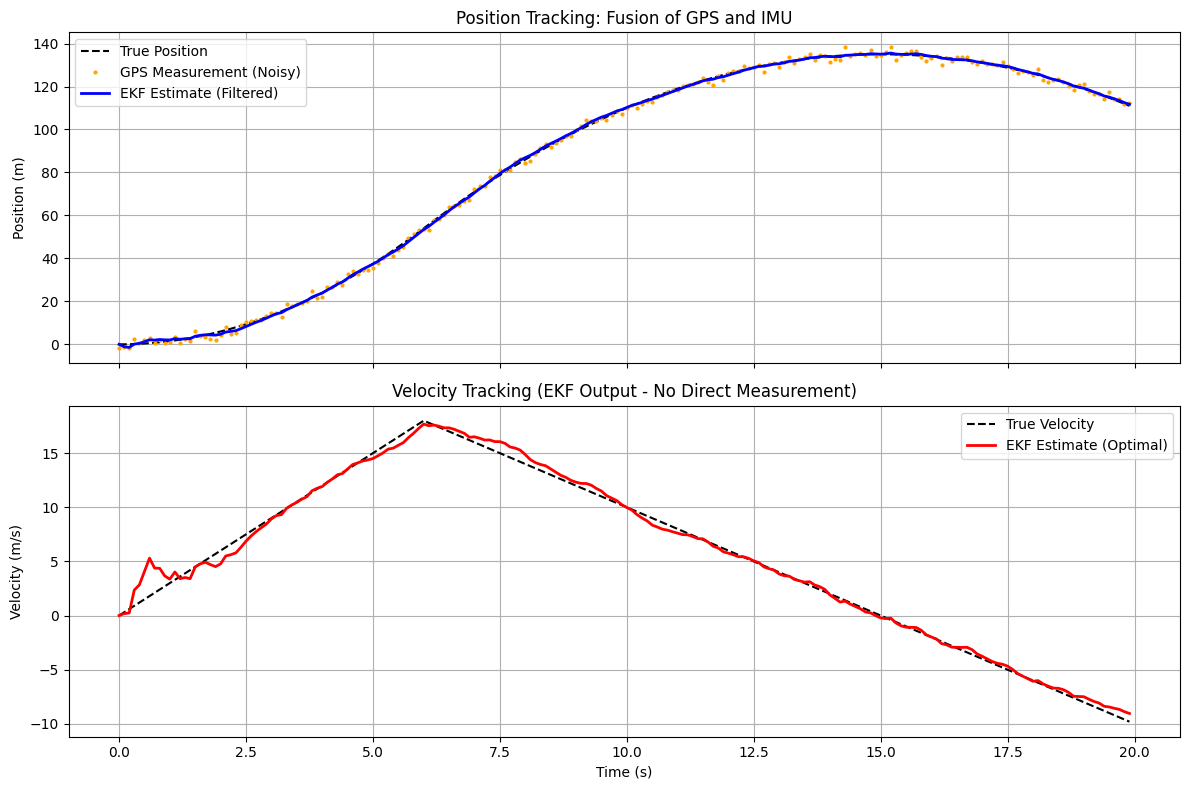

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. SYSTEM DEFINITION AND CONSTANTS
# =============================================================================

# State Vector: X = [position (p), velocity (v), acceleration (a)]
STATE_DIM = 3
# Measurement Vector: Z = [GPS position (p_gps), IMU acceleration (a_imu)]
MEASUREMENT_DIM = 2
DT = 0.1  # Time step (seconds)

class System:
    """Defines the initial state and noise parameters for the EKF."""

    # --- TRUE SYSTEM INITIAL STATE ---
    X0 = np.array([0.0, 0.0, 0.0])  # Initial [p, v, a]

    # --- EKF INITIAL STATE and COVARIANCE ---
    # Initial estimate of the state (often just X0)
    X_ESTIMATE_0 = np.array([0.0, 0.0, 0.0])

    # Initial state covariance P0 (high uncertainty to start)
    # The diagonal represents the variance of [p, v, a]
    P0 = np.diag([100.0, 10.0, 1.0])

    # --- NOISE COVARIANCE MATRICES ---

    # 1. Process Noise (Q): Uncertainty in the physical model (unmodeled forces/jerks)
    # The higher the value, the more the filter trusts the measurements.
    # [position, velocity, acceleration]
    Q = np.diag([0.01, 0.01, 0.1])

    # 2. Measurement Noise (R): Sensor uncertainty
    # [GPS position variance, IMU acceleration variance]
    R = np.diag([2.0, 0.5])
    # GPS is highly accurate but slow (low variance), IMU is fast but noisy (higher variance)


# =============================================================================
# 2. KALMAN FILTER CORE FUNCTIONS (PREDICTION AND UPDATE)
# =============================================================================

def state_transition_matrix(dt):
    """
    Calculates the Jacobian F (or A) for the prediction step.
    This matrix implements the physics:
    p_k = p_{k-1} + v_{k-1}*dt + 0.5*a_{k-1}*dt^2
    v_k = v_{k-1} + a_{k-1}*dt
    a_k = a_{k-1}
    """
    return np.array([
        [1, dt, 0.5 * dt**2],
        [0, 1, dt],
        [0, 0, 1]
    ])

def measurement_matrix():
    """
    Calculates the Jacobian H for the measurement step.
    This tells the filter how the measurements Z relate to the state X:
    Z = [p_gps, a_imu]
    """
    # Z = H * X
    return np.array([
        [1, 0, 0],  # GPS measures position (p)
        [0, 0, 1]   # IMU measures acceleration (a)
    ])


def extended_kalman_filter(X_est, P, Z, dt, Q, R):
    """
    Performs one cycle of the EKF: Prediction + Update.
    The system is linear, so F and H are constant matrices (Jacobians are trivial).
    """

    # --- 1. PREDICTION STEP ---

    # 1.1 State Prediction (X_pred): Use physics model to estimate next state
    F = state_transition_matrix(dt)
    X_pred = F @ X_est

    # 1.2 Covariance Prediction (P_pred): Propagate uncertainty
    # P_pred = F * P * F^T + Q
    P_pred = F @ P @ F.T + Q

    # --- 2. MEASUREMENT UPDATE STEP ---

    H = measurement_matrix()

    # 2.1 Innovation Covariance (S): Combined uncertainty of prediction and measurement
    # S = H * P_pred * H^T + R
    S = H @ P_pred @ H.T + R

    # 2.2 Kalman Gain (K): Optimal blend factor
    # K = P_pred * H^T * S^{-1}
    K = P_pred @ H.T @ np.linalg.inv(S)

    # 2.3 Residual (y): Difference between actual measurement and predicted measurement
    # The predicted measurement is H @ X_pred
    y = Z - (H @ X_pred)

    # 2.4 State Update (X_est): Correct the predicted state
    # X_est = X_pred + K * y
    X_est_new = X_pred + K @ y

    # 2.5 Covariance Update (P_new): Reduce uncertainty
    # P_new = (I - K * H) * P_pred
    I = np.eye(STATE_DIM)
    P_new = (I - K @ H) @ P_pred

    return X_est_new, P_new


# =============================================================================
# 3. SIMULATION AND DATA GENERATION
# =============================================================================

def generate_true_trajectory(total_time, dt):
    """Creates a true, noise-free trajectory for testing."""
    times = np.arange(0, total_time, dt)
    n_steps = len(times)

    # True trajectory storage [p, v, a]
    X_true = np.zeros((n_steps, STATE_DIM))
    X_true[0] = System.X0

    # Define a complex true acceleration profile (e.g., constant thrust, then coast)
    true_accel_profile = np.concatenate([
        np.full(int(0.3 * n_steps), 3.0), # Constant acceleration phase
        np.full(n_steps - int(0.3 * n_steps), -2.0) # Braking/Deceleration phase
    ])

    for k in range(n_steps - 1):
        # Apply the discrete physics model F to the true state
        F = state_transition_matrix(dt)
        X_true[k+1] = F @ X_true[k]

        # Override the a_k = a_{k-1} assumption with the true profile
        X_true[k+1, 2] = true_accel_profile[k]

        # Recalculate p and v based on the new (known) true acceleration
        X_true[k+1, 1] = X_true[k, 1] + X_true[k+1, 2] * dt # v
        X_true[k+1, 0] = X_true[k, 0] + X_true[k, 1] * dt + 0.5 * X_true[k+1, 2] * dt**2 # p

    return times, X_true

def generate_noisy_measurements(X_true):
    """Generates measurements with realistic noise based on R matrix."""
    n_steps = X_true.shape[0]

    # GPS noise std dev (sqrt of R[0,0])
    gps_noise = np.sqrt(System.R[0, 0])
    # IMU noise std dev (sqrt of R[1,1])
    imu_noise = np.sqrt(System.R[1, 1])

    Z_noisy = np.zeros((n_steps, MEASUREMENT_DIM))

    # 1. GPS (Position, X_true[:, 0])
    Z_noisy[:, 0] = X_true[:, 0] + np.random.normal(0, gps_noise, n_steps)

    # 2. IMU (Acceleration, X_true[:, 2])
    Z_noisy[:, 1] = X_true[:, 2] + np.random.normal(0, imu_noise, n_steps)

    return Z_noisy


# =============================================================================
# 4. MAIN EXECUTION AND VISUALIZATION
# =============================================================================

def run_simulation(total_time):
    """Runs the full simulation: data generation, EKF, and plotting."""

    # 1. Generate Data
    times, X_true = generate_true_trajectory(total_time, DT)
    Z_noisy = generate_noisy_measurements(X_true)
    n_steps = len(times)

    # 2. Initialize EKF
    X_est = System.X_ESTIMATE_0
    P = System.P0

    # Store results
    X_history = np.zeros((n_steps, STATE_DIM))
    X_history[0] = X_est

    # 3. EKF Loop
    for k in range(1, n_steps):
        # Get the noisy measurement for the current step
        Z_k = Z_noisy[k]

        # Run the EKF cycle (Prediction and Update)
        X_est, P = extended_kalman_filter(X_est, P, Z_k, DT, System.Q, System.R)

        X_history[k] = X_est

    print(f"EKF simulation complete. Total steps: {n_steps}")

    # 4. Plotting
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # --- Position Plot ---
    ax = axes[0]
    ax.plot(times, X_true[:, 0], 'k--', label='True Position')
    ax.plot(times, Z_noisy[:, 0], 'o', markersize=2, color='orange', label='GPS Measurement (Noisy)')
    ax.plot(times, X_history[:, 0], color='blue', linewidth=2, label='EKF Estimate (Filtered)')
    ax.set_title('Position Tracking: Fusion of GPS and IMU')
    ax.set_ylabel('Position (m)')
    ax.legend()
    ax.grid(True)

    # --- Velocity Plot ---
    ax = axes[1]
    # Note: GPS doesn't measure velocity directly, but the EKF estimates it optimally!
    ax.plot(times, X_true[:, 1], 'k--', label='True Velocity')
    ax.plot(times, X_history[:, 1], color='red', linewidth=2, label='EKF Estimate (Optimal)')
    ax.set_title('Velocity Tracking (EKF Output - No Direct Measurement)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Velocity (m/s)')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Run a 20-second simulation
    run_simulation(total_time=20.0)


--------------------------------------------------
ANALYSIS SUMMARY (Velocity Uncertainty)
--------------------------------------------------
Scenario A (Trusting GPS): Filter is highly confident in velocity because position is accurate.
  Final Velocity Variance: 0.2643

Scenario B (Trusting IMU): Filter relies on integration of IMU data, increasing initial uncertainty.
  Final Velocity Variance: 0.2665
--------------------------------------------------


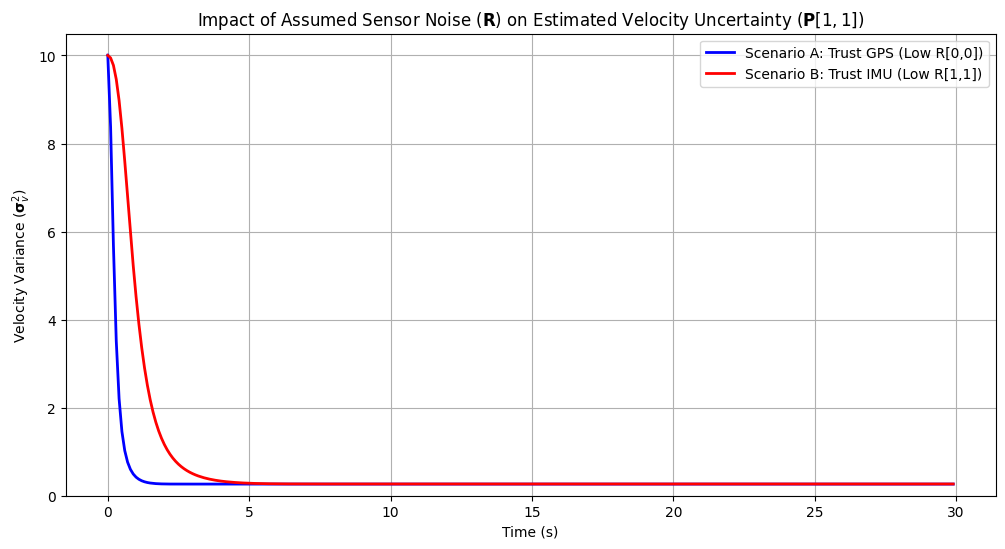

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. SYSTEM DEFINITION AND CONSTANTS
# =============================================================================

# State Vector: X = [position (p), velocity (v), acceleration (a)]
STATE_DIM = 3
# Measurement Vector: Z = [GPS position (p_gps), IMU acceleration (a_imu)]
MEASUREMENT_DIM = 2
DT = 0.1  # Time step (seconds)

class System:
    """Defines the initial state and noise parameters for the EKF."""

    # --- TRUE SYSTEM INITIAL STATE ---
    X0 = np.array([0.0, 0.0, 0.0])  # Initial [p, v, a]

    # --- EKF INITIAL STATE and COVARIANCE ---
    X_ESTIMATE_0 = np.array([0.0, 0.0, 0.0])
    P0 = np.diag([100.0, 10.0, 1.0])

    # 1. Process Noise (Q): Uncertainty in the physical model
    # Remains constant for all scenarios.
    Q = np.diag([0.01, 0.01, 0.1])

    # 2. Base Measurement Noise (R): Sensor uncertainty
    # This will be overridden in the analysis function.
    R_BASE = np.diag([2.0, 0.5])


# =============================================================================
# 2. KALMAN FILTER CORE FUNCTIONS
# =============================================================================

def state_transition_matrix(dt):
    """
    Jacobian F: Implements the physics: p_k, v_k update rules.
    """
    return np.array([
        [1, dt, 0.5 * dt**2],
        [0, 1, dt],
        [0, 0, 1]
    ])

def measurement_matrix():
    """
    Jacobian H: Maps state X to measurement Z: Z = [p, a].
    """
    return np.array([
        [1, 0, 0],  # GPS measures position (p)
        [0, 0, 1]   # IMU measures acceleration (a)
    ])


def extended_kalman_filter(X_est, P, Z, dt, Q, R):
    """Performs one cycle of the EKF: Prediction + Update."""

    # --- 1. PREDICTION STEP ---
    F = state_transition_matrix(dt)
    X_pred = F @ X_est
    P_pred = F @ P @ F.T + Q

    # --- 2. MEASUREMENT UPDATE STEP ---
    H = measurement_matrix()

    # Innovation Covariance (S)
    S = H @ P_pred @ H.T + R

    # Kalman Gain (K)
    K = P_pred @ H.T @ np.linalg.inv(S)

    # Residual (y)
    y = Z - (H @ X_pred)

    # State Update (X_est)
    X_est_new = X_pred + K @ y

    # Covariance Update (P_new)
    I = np.eye(STATE_DIM)
    P_new = (I - K @ H) @ P_pred

    return X_est_new, P_new


# =============================================================================
# 3. SIMULATION AND DATA GENERATION
# =============================================================================

def generate_true_trajectory(total_time, dt):
    """Creates a true, noise-free trajectory."""
    times = np.arange(0, total_time, dt)
    n_steps = len(times)

    X_true = np.zeros((n_steps, STATE_DIM))
    X_true[0] = System.X0

    # Define a complex true acceleration profile
    true_accel_profile = np.concatenate([
        np.full(int(0.3 * n_steps), 3.0),   # Constant acceleration phase
        np.full(int(0.1 * n_steps), 0.0),   # Coast phase
        np.full(n_steps - int(0.4 * n_steps), -2.0) # Braking phase
    ])

    for k in range(n_steps - 1):
        F = state_transition_matrix(dt)
        X_true[k+1] = F @ X_true[k]

        # Apply the true acceleration profile
        X_true[k+1, 2] = true_accel_profile[k]

        # Recalculate p and v based on the new (known) true acceleration
        X_true[k+1, 1] = X_true[k, 1] + X_true[k+1, 2] * dt
        X_true[k+1, 0] = X_true[k, 0] + X_true[k, 1] * dt + 0.5 * X_true[k+1, 2] * dt**2

    return times, X_true

def generate_noisy_measurements(X_true, R_matrix):
    """Generates measurements with specific noise based on the R matrix."""
    n_steps = X_true.shape[0]

    gps_noise = np.sqrt(R_matrix[0, 0])
    imu_noise = np.sqrt(R_matrix[1, 1])

    Z_noisy = np.zeros((n_steps, MEASUREMENT_DIM))

    # 1. GPS (Position)
    Z_noisy[:, 0] = X_true[:, 0] + np.random.normal(0, gps_noise, n_steps)

    # 2. IMU (Acceleration)
    Z_noisy[:, 1] = X_true[:, 2] + np.random.normal(0, imu_noise, n_steps)

    return Z_noisy

def run_scenario(X_true, Z_noisy, R_matrix, label):
    """Runs the EKF for a specific R matrix configuration."""
    n_steps = X_true.shape[0]
    X_est = System.X_ESTIMATE_0
    P = System.P0

    # Store history for state and covariance [p, v, a]
    P_history = np.zeros((n_steps, STATE_DIM))

    # EKF Loop
    for k in range(n_steps):
        Z_k = Z_noisy[k]
        X_est, P = extended_kalman_filter(X_est, P, Z_k, DT, System.Q, R_matrix)

        # Store the variance (diagonal) of the covariance matrix P
        P_history[k] = np.diag(P)

    return P_history, label

# =============================================================================
# 4. COVARIANCE ANALYSIS AND PLOTTING
# =============================================================================

def analyze_covariance_impact(total_time):
    """
    Analyzes the impact of assumed sensor noise (R matrix) on the
    estimated uncertainty (P matrix).
    """

    # 1. Generate a single TRUE trajectory for both scenarios
    times, X_true = generate_true_trajectory(total_time, DT)

    # --- SCENARIO A: Trusting GPS More (Standard Setup) ---
    # GPS noise (R[0,0]) is low (0.5^2 = 0.25)
    # IMU noise (R[1,1]) is high (1.5^2 = 2.25)
    R_A = np.diag([0.25, 2.25])
    Z_noisy_A = generate_noisy_measurements(X_true, R_A)
    P_history_A, label_A = run_scenario(X_true, Z_noisy_A, R_A, 'Scenario A: Trust GPS (Low R[0,0])')

    # --- SCENARIO B: Trusting IMU More ---
    # GPS noise (R[0,0]) is high (3.0^2 = 9.0)
    # IMU noise (R[1,1]) is low (0.1^2 = 0.01)
    R_B = np.diag([9.0, 0.01])
    Z_noisy_B = generate_noisy_measurements(X_true, R_B)
    P_history_B, label_B = run_scenario(X_true, Z_noisy_B, R_B, 'Scenario B: Trust IMU (Low R[1,1])')

    # 2. Plotting the Velocity Uncertainty (P[1, 1])
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # P_history[:, 1] corresponds to the Velocity Variance (P[1,1])
    ax.plot(times, P_history_A[:, 1], color='blue', linewidth=2, label=label_A)
    ax.plot(times, P_history_B[:, 1], color='red', linewidth=2, label=label_B)

    ax.set_title('Impact of Assumed Sensor Noise ($\mathbf{R}$) on Estimated Velocity Uncertainty ($\mathbf{P}[1, 1]$)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Velocity Variance ($\mathbf{\sigma}_{v}^2$)')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(bottom=0) # Variance must be non-negative

    # 3. Print Summary
    print("-" * 50)
    print("ANALYSIS SUMMARY (Velocity Uncertainty)")
    print("-" * 50)
    print("Scenario A (Trusting GPS): Filter is highly confident in velocity because position is accurate.")
    print(f"  Final Velocity Variance: {P_history_A[-1, 1]:.4f}")
    print("\nScenario B (Trusting IMU): Filter relies on integration of IMU data, increasing initial uncertainty.")
    print(f"  Final Velocity Variance: {P_history_B[-1, 1]:.4f}")
    print("-" * 50)

    plt.show()

if __name__ == '__main__':
    # Run a 30-second simulation to see the long-term convergence
    analyze_covariance_impact(total_time=30.0)
